In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Function to read a image
# if image is png scale the image
def read_image(img):
    if img.endswith('png'):
        return (mpimg.imread(img)*255).astype('uint8')
    else:
        return mpimg.imread(img)

In [3]:
#function to draw list of bounding boxes in image
def draw_boxes(img, bboxes, color = (0, 0, 255), thick = 6):
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    return img_copy

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

In [5]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


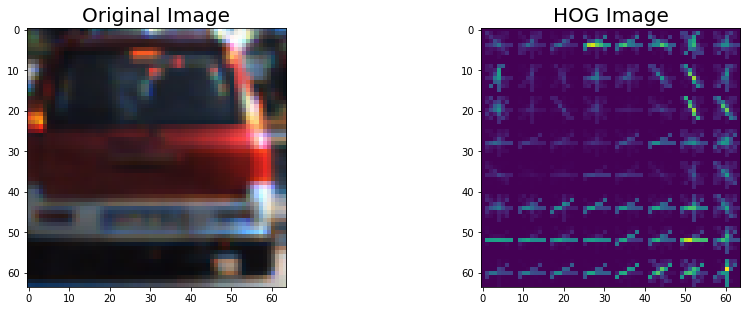

In [7]:
# Visualize HOG Features generated by car image
# The HOG feature will be input to the classifer
test_img = read_image('./vehicles/KITTI_extracted/32.png')
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(test_img_gray, orient = 8, pix_per_cell = 8, cell_per_block = 2, vis=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hog_image)
ax2.set_title('HOG Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
# Define a function to extract features from a single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    # Do Color Conversion
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    #Add Spatial Binning Features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    #Add Histogram Features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    #Add HOG Features
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    return np.concatenate(img_features)

In [9]:
#Function to create features vector for list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        image = read_image(file)
        file_features = single_img_features(image, color_space, spatial_size, hist_bins, 
                                            orient, pix_per_cell, cell_per_block, 
                                            hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    return features

In [10]:
# Read All the car and non-car images path
cars = glob.glob('vehicles/**/*.png', recursive = True);
notcars = glob.glob('non-vehicles/**/*.png', recursive = True);

In [11]:
print('Total cars images are {0}'.format(len(cars)))
print('Total non cars images are {0}'.format(len(notcars)))

Total cars images are 8792
Total non cars images are 8968


In [12]:
# Paramters to be used to extract features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [13]:
# Extract Car Features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [14]:
# Extract Non Car Features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
# Normalize the feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [16]:
# Generate labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [17]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [18]:
print("Total training data is {0}".format(len(X_train)))
print("Total test data is {0}".format(len(X_test)))

Total training data is 14208
Total test data is 3552


In [19]:
# Create SVC classifier and train it
# Validate the performance on test data by calculating accuracy.
import time
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

14.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


In [20]:
# Function to generate windows to be searched.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [21]:
# Take a list of windows and search for cars in those windows by creating feature vector for each window and using classier 
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

Total windows to search 601


/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


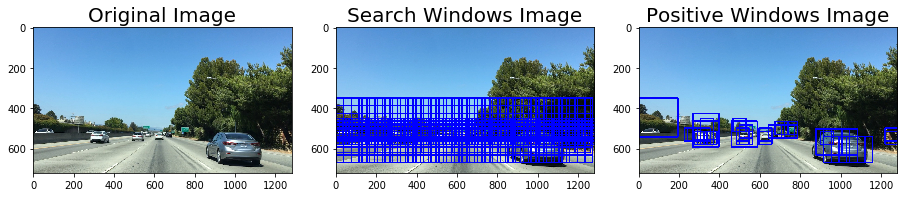

In [22]:
# Multiscale sliding window search
test_img = read_image('./cutouts/bbox-example-image.jpg')
windows = [(64, 64), (128, 128), (192, 192)]
overlap = [0.75, 0.7, 0.6]
y_start_stop = [[450, 580], [350, 684], [350, 684]]

windows_to_search = []
for i in range(len(windows)):
    temp = slide_window(test_img, y_start_stop=y_start_stop[i], xy_window=windows[i], xy_overlap=(overlap[i], overlap[i]))
    windows_to_search.extend(temp)

print('Total windows to search {0}'.format(len(windows_to_search)))

positive_windows = search_windows(test_img, windows_to_search, 
                                  clf = svc, scaler = X_scaler, 
                                  color_space = color_space, 
                                  spatial_size = spatial_size, 
                                  hist_bins = hist_bins, 
                                  orient = orient, pix_per_cell = pix_per_cell, 
                                  cell_per_block = cell_per_block, hog_channel = hog_channel)

img_with_search_windows = draw_boxes(test_img, windows_to_search)
img_with_positive_windows = draw_boxes(test_img, positive_windows)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img_with_search_windows)
ax2.set_title('Search Windows Image', fontsize=20)
ax3.imshow(img_with_positive_windows)
ax3.set_title('Positive Windows Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [23]:
# Function to generate image with heat map
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

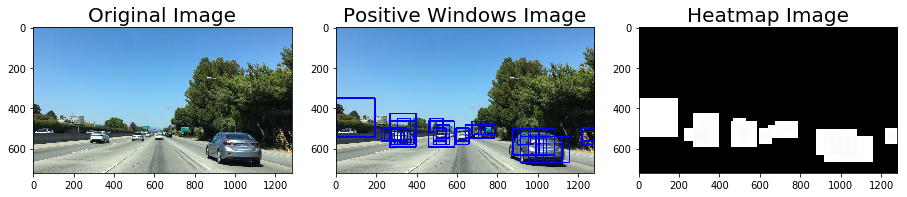

In [24]:
# Visualize Heatmap without threshold
test_img_shape = test_img.shape
heatmap = add_heat(np.zeros(test_img_shape), positive_windows)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img_with_positive_windows)
ax2.set_title('Positive Windows Image', fontsize=20)
ax3.imshow(heatmap)
ax3.set_title('Heatmap Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [25]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

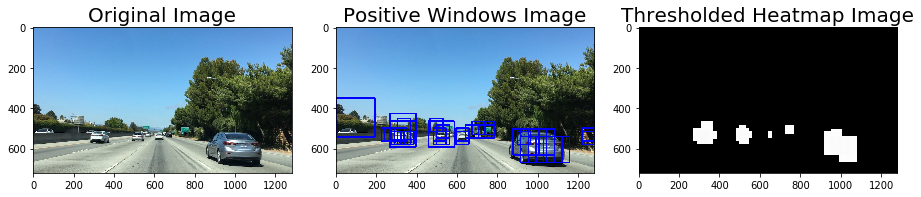

In [26]:
# Visualize Heatmap with threshold
test_img_shape = test_img.shape
heatmap = add_heat(np.zeros(test_img_shape), positive_windows)
threholded_heatmap = apply_threshold(heatmap, threshold = 2)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img_with_positive_windows)
ax2.set_title('Positive Windows Image', fontsize=20)
ax3.imshow(threholded_heatmap)
ax3.set_title('Thresholded Heatmap Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [27]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

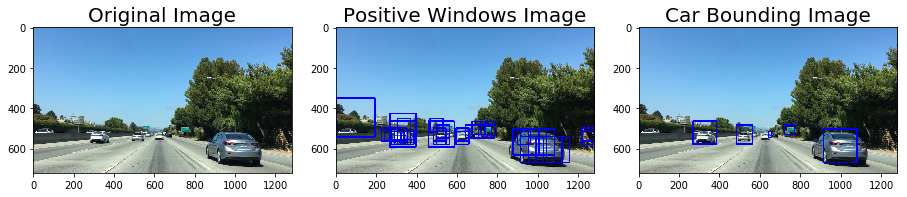

In [28]:
#Visualize after generating labels for threholded image
from scipy.ndimage.measurements import label
labels = label(threholded_heatmap)
img_with_car = draw_labeled_bboxes(np.copy(test_img), labels)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img_with_positive_windows)
ax2.set_title('Positive Windows Image', fontsize=20)
ax3.imshow(img_with_car)
ax3.set_title('Car Bounding Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
# Function to convert from RGB to different color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [30]:
# Function to find cars in image by using HOG subsampling
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
     
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))       
    return car_windows

In [31]:
# Class that search for windows having cards using HOG subsampling function using different scales
from scipy.ndimage.measurements import label
class SearchCars:
    def __init__(self, clf, X_scaler, 
                 color_space, spatial_size, 
                 hist_bins, orient, pix_per_cell, 
                 cell_per_block, hog_channel, 
                 spatial_feat, hist_feat, hog_feat):
        self.clf = clf
        self.X_scaler = X_scaler
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        
        
    def find_hot_windows(self, img):
        ystart = [350, 380, 380]
        ystop =  [656, 712, 712]
        scale =  [1.0, 1.5, 2.0]
        
        hot_windows = []
        for i in range(len(scale)):
            car_windows = find_cars(img, ystart[i], ystop[i], scale[i], 
                                self.clf, self.X_scaler, 
                                self.orient, self.pix_per_cell, 
                                self.cell_per_block, self.spatial_size, self.hist_bins)
            hot_windows.extend(car_windows)
        return hot_windows
        

In [32]:
search_cars = SearchCars(svc, X_scaler, color_space, 
                         spatial_size, hist_bins, orient,
                         pix_per_cell, cell_per_block, 
                         hog_channel, spatial_feat, 
                         hist_feat, hog_feat)

In [33]:
test_img = read_image('cutouts/bbox-example-image.jpg')

/Users/arthur/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


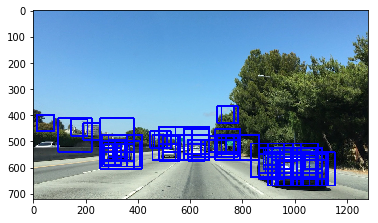

In [34]:
hot_windows = search_cars.find_hot_windows(test_img)
draw_img = draw_boxes(test_img, hot_windows)
plt.imshow(draw_img)
plt.show()

In [35]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=5, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = search_cars.find_hot_windows(img)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('./project_video.mp4', './output_project_video.mp4', threshhold=2)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████▉| 1260/1261 [46:52<00:02,  2.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 



In [36]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_project_video.mp4'))